In [1]:
from typing import Union, Any, Optional, Callable, Tuple
from abc import ABC, abstractmethod
import eagerpy as ep

from foolbox.devutils import flatten
from foolbox.devutils import atleast_kd

from foolbox.types import Bounds

from foolbox.models.base import Model

from foolbox.criteria import Misclassification, TargetedMisclassification

from foolbox.distances import l1, l2, linf

from foolbox.attacks.base import FixedEpsilonAttack
from foolbox.attacks.base import T
from foolbox.attacks.base import get_criterion
from foolbox.attacks.base import raise_if_kwargs

def _get_loss_fn(self, model: Model, labels: ep.Tensor, original_lengths=None) -> Callable[[ep.Tensor], ep.Tensor]:
    # can be overridden by users
    def loss_fn(inputs: ep.Tensor, original_lengths) -> ep.Tensor:
        logits = model(inputs, original_lengths)
        return ep.crossentropy(logits, labels).sum()

    return loss_fn

def _value_and_grad(
    # can be overridden by users
    self,
    loss_fn: Callable[[ep.Tensor], ep.Tensor],
    x: ep.Tensor,
    original_lengths: ep.Tensor,
) -> Tuple[ep.Tensor, ep.Tensor]:
    return ep.value_and_grad(loss_fn, x, original_lengths)

def _run(
    self,
    model: Model,
    inputs: T,
    criterion: Union[Misclassification, TargetedMisclassification, T],
    *,
    epsilon: float,
    **kwargs: Any,
) -> T:
#     raise_if_kwargs(kwargs)
    x0, restore_type = ep.astensor_(inputs)
    criterion_ = get_criterion(criterion)
    original_lengths = kwargs['original_lengths']
    del inputs, criterion, kwargs

    # perform a gradient ascent (targeted attack) or descent (untargeted attack)
    if isinstance(criterion_, Misclassification):
        gradient_step_sign = 1.0
        classes = criterion_.labels
    elif hasattr(criterion_, "target_classes"):
        gradient_step_sign = -1.0
        classes = criterion_.target_classes  # type: ignore
    else:
        raise ValueError("unsupported criterion")

    loss_fn = self.get_loss_fn(model, classes)

    if self.abs_stepsize is None:
        stepsize = self.rel_stepsize * epsilon
    else:
        stepsize = self.abs_stepsize

    if self.random_start:
        x = self.get_random_start(x0, epsilon)
        x = ep.clip(x, *model.bounds)
    else:
        x = x0

    for _ in range(self.steps):
        _, gradients = self.value_and_grad(loss_fn, x, original_lengths) #!!!!
        gradients = self.normalize(gradients, x=x, bounds=model.bounds)
        x = x + gradient_step_sign * stepsize * gradients
        x = self.project(x, x0, epsilon)
        x = ep.clip(x, *model.bounds)

    return restore_type(x)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/homedirs/nikoghos/project-1/"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

pkg_path = "/nfs/homedirs/nikoghos/project-1/foolbox"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import os
import time
import types
import yaml
import torch
from audio_classification.tools import do_train, get_dataloader, get_model, get_transform
from audio_classification.tools.train_net import collate
from audio_classification.model import lit_m11, LitCRNN
from audio_classification.data import BMWDataset, UrbanSoundDataset

from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, L2PGD, FGM, FGSM

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.cuda.empty_cache()
device = torch.device('cpu')
# device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
project_dir = '/nfs/homedirs/nikoghos/project-1/'
save_folder = '/nfs/homedirs/nikoghos/project-1/attack_results/'

In [3]:
device

device(type='cpu')

In [4]:
def attack_model(project_dir, config_path, pretrained_path, title):
    with open(os.path.join(project_dir, config_path), "r") as config_file:
        configs = yaml.load(config_file)
    print(configs)

    # use validattion set
    val_set = BMWDataset(configs, [11], transform=get_transform(configs)) # actually the test set
#     val_set = UrbanSoundDataset(configs, [10], transform=get_transform(configs))
    val_loader = DataLoader(val_set, batch_size=24, shuffle=False,
                                    num_workers=configs["DATALOADER"]["NUM_WORKERS"],
                                    pin_memory=True, collate_fn = collate)

    # Get the upper bound and lower bound on the values of the data, to be used as constraint in PGD
    lower_bounds = []
    upper_bounds = []
    for step, (x, y, seq_lens) in enumerate(val_loader): 
        upper_bounds.append(torch.max(x))
        lower_bounds.append(torch.min(x))
    
    lower_bound = min(lower_bounds)
    upper_bound = max(upper_bounds)
    print("Range of the input data is (%f, %f)" %(lower_bound, upper_bound))

    path_to_checkpoint = os.path.join(project_dir, pretrained_path)
    # Get the class weights, used in reloading the model
    if configs['DATASET']['WEIGHT']=='NORMAL':
        weight = torch.tensor([28.9047, 14.8049,  4.5985,  2.4675,  4.4632, 19.5806]).to(device=device)
    elif configs['DATASET']['WEIGHT']=='SQUARED':
        weight = torch.tensor([835.4845, 219.1843,  21.1461,   6.0885,  19.9205, 383.4014]).to(device=device)
    else:
        weight = None

    model = LitCRNN.load_from_checkpoint(path_to_checkpoint, cfg=configs, class_weights=weight, strict=False, map_location=device)
    fmodel = PyTorchModel(model, bounds=(lower_bound, upper_bound), device=device)

    # evaluate accuracy on clean data on a batch
    it = iter(val_loader)
    batch = next(it)
    clips = batch[0].to(device)
    labels = batch[1].to(device)
    lengths = batch[2].to(device)   # used only for CRNN

    # delete some variables to free up memory
    del model
    del it
    del val_loader
    del val_set

    # evaluate robustness with L-inf Fast Gradient Attack
    torch.cuda.empty_cache()
    attack = FGSM()

    attack.run = types.MethodType(_run, attack)
    attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
    attack.value_and_grad = types.MethodType(_value_and_grad, attack)
    epsilons = np.linspace(0.0, 10, num=20)

    start_time = time.perf_counter()
    raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
    end_time = time.perf_counter()
    print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

    robust_accuracy = 1 - is_adv.double().mean(axis=-1)
    print(robust_accuracy)

    plt.title("L-inf Fast Gradient Attack")
    plt.xlabel("epsilon")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.1)
    plt.plot(epsilons, robust_accuracy.to('cpu').numpy())
    plt.savefig(save_folder + title + '-linf-20.png')


{'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw', 'SAVE_PATH': '../weights/crnn_bmw', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 4, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/homedirs/nikoghos/BMW/meta/bmw.csv', 'FOLDER_PATH': '/nfs/homedirs/nikoghos/Brake_Noise', 'NAME': 'BMW', 'VAL_FOLD': 2, 'WEIGHT': 'NORMAL'}, 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'MIXUP': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 6}, 'SOLVER': {'ALPHA': 1.7522326562381854, 'GAMMA': 0.1, 'LEARNING_RATE': 0.00021701925536763377, 'LOG_PATH': '../logs/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 10, 'NUM_GPUS': 1, 'STEP_SIZE': 10, 'WEIGHT_DECAY': 2.9720995669595073e-08}}
Range of the input data is (-80.977570, 42.630302)


/nfs/homedirs/nikoghos/anaconda3/lib/python3.8/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


Generated attacks in 1619.88 seconds
tensor([0.6250, 0.5000, 0.2917, 0.2917, 0.2917, 0.2083, 0.0833, 0.0417, 0.0833,
        0.0417, 0.0833, 0.0833, 0.0000, 0.0417, 0.0833, 0.0417, 0.0417, 0.0000,
        0.0000, 0.0417], dtype=torch.float64)


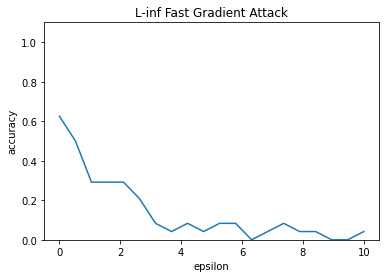

In [5]:
title = 'bmw_merged_mixup'
config_path = 'logs/default/version_53_bmwmerged/hparams.yaml' #fold2
# config_path = 'logs/default/version_24/hparams.yaml' #fold10

pretrained_path = 'weights/crnn_bmw/crnn-bmwmerged-epoch=15-val_acc=0.934.ckpt'

attack_model(project_dir, config_path, pretrained_path, title)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'VAL_FOLD': 2, 'WEIGHT': 'NORMAL'}, 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'MIXUP': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'ALPHA': 0.7608399210841633, 'GAMMA': 0.1, 'LEARNING_RATE': 0.0004881731392294949, 'LOG_PATH': '../logs/', 'MAX_EPOCH': 35, 'MIN_EPOCH': 10, 'NUM_GPUS': 1, 'STEP_SIZE': 7, 'WEIGHT_DECAY': 2.628328526113425e-08}}
Range of the input data is (-100.000000, 43.114243)


/nfs/homedirs/nikoghos/anaconda3/lib/python3.8/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


Generated attacks in 0.72 seconds
tensor([1.0000, 1.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.5000, 0.5000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.5000, 0.5000,
        0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0000, 0.5000,
        0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000,
        0.0000], device='cuda:0', dtype=torch.float64)


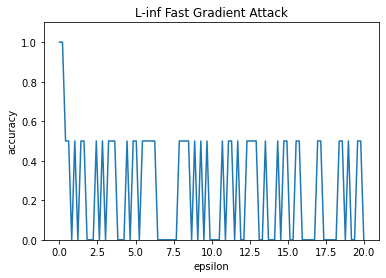

In [7]:
# Urbansound8k (Compare the effect of label smoothing)
title = 'us8k_mixup'
config_path = 'logs/default/version_36_mixup_us8k/hparams.yaml' #fold2
# config_path = 'logs/default/version_24/hparams.yaml' #fold10

pretrained_path = 'weights/crnn-us8k_fold2-epoch=16-val_acc=0.779.ckpt'

attack_model(project_dir, config_path, pretrained_path, title)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 6, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'VAL_FOLD': 10, 'WEIGHT': 'NORMAL'}, 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'MIXUP': False}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'ALPHA': 0.7608399210841633, 'GAMMA': 0.1, 'LEARNING_RATE': 0.0004881731392294949, 'LOG_PATH': '../logs/', 'MAX_EPOCH': 35, 'MIN_EPOCH': 10, 'NUM_GPUS': 1, 'STEP_SIZE': 7, 'WEIGHT_DECAY': 2.628328526113425e-08}}
Range of the input data is (-100.000000, 43.114243)


/nfs/homedirs/nikoghos/anaconda3/lib/python3.8/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


Generated attacks in 0.71 seconds
tensor([1.0000, 1.0000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000,
        0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.5000,
        0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:0', dtype=torch.float64)


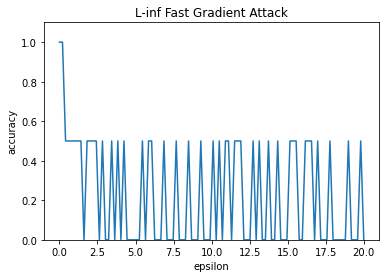

In [8]:

title = 'us8k_baseline'
#config_path = 'logs/default/version_45_baseline_us8k/hparams.yaml' #fold2
config_path = 'logs/default/version_46_baseline_us8k/hparams.yaml'
pretrained_path = 'weights/crnn-us8k_fold10_baseline-epoch=02-val_acc=0.777.ckpt'

attack_model(project_dir, config_path, pretrained_path, title)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw', 'SAVE_PATH': '../weights/crnn_bmw', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 4, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'NAME': 'BMW', 'VAL_FOLD': 4, 'WEIGHT': 'NORMAL'}, 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'MIXUP': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 6}, 'SOLVER': {'ALPHA': 1.7522326562381854, 'GAMMA': 0.1, 'LEARNING_RATE': 0.00021701925536763377, 'LOG_PATH': '../logs/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 10, 'NUM_GPUS': 1, 'STEP_SIZE': 10, 'WEIGHT_DECAY': 2.9720995669595073e-08}}
Range of the input data is (-82.704231, 41.936913)


/nfs/homedirs/nikoghos/anaconda3/lib/python3.8/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


Generated attacks in 1605.19 seconds
tensor([0.5417, 0.5000, 0.4167, 0.3333, 0.3750, 0.2083, 0.2917, 0.2917, 0.3333,
        0.2917, 0.2500, 0.2083, 0.1250, 0.0833, 0.2917, 0.2500, 0.2500, 0.2500,
        0.1250, 0.2083], dtype=torch.float64)


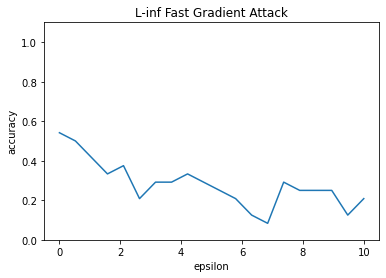

In [5]:
title = 'bmw_mixup'
config_path = 'logs/default/version_6/hparams.yaml'
pretrained_path = 'weights/crnn_bmw/crnn-bmw_fold4-epoch=40-val_acc=0.960.ckpt'

attack_model(project_dir, config_path, pretrained_path, title)

In [1]:
# # Visualize adverserial sample
# attack = FGM()

# attack.run = types.MethodType(_run, attack)
# attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
# attack.value_and_grad = types.MethodType(_value_and_grad, attack)
# # raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=40)
# raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=100, original_lengths=lengths)

# is_adv = is_adv.cpu()
# clipped = clipped.cpu()

In [ ]:
# try:
#     idx = np.where(is_adv.cpu().numpy()==True)[0][0]
#     print("Visualize for the number %s sample in the batch" %(idx))

#     # Visualize attack sample
#     out = model(clipped.to(device), lengths)
#     preds = torch.argmax(out, dim=1)

#     idx = np.where(is_adv.cpu().numpy()==True)[0][0]
#     sample = clipped[idx]
#     print("label %s" %(preds[idx]))
#     print(sample[0].shape)
#     plt.pcolormesh(sample[0].squeeze().numpy(), shading='gouraud')
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.show()
    
#     # Visualize original sample
#     sample = batch[0]
#     print("label %s" %(batch[1][idx]))
#     print(sample[idx].shape)
#     plt.pcolormesh(sample[idx].squeeze().numpy(), shading='gouraud')
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.show()
# except:
#     print("No adversarial sample to show.")

In [ ]:
# # evaluate robustness with L-inf Fast Gradient Attack
# torch.cuda.empty_cache()
# attack = FGSM()

# attack.run = types.MethodType(_run, attack)
# attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
# attack.value_and_grad = types.MethodType(_value_and_grad, attack)
# epsilons = np.linspace(0.0, 1, num=20)

# start_time = time.perf_counter()
# raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
# end_time = time.perf_counter()
# print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

# robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
# plt.title("L-inf Fast Gradient Attack")
# plt.xlabel("epsilon")
# plt.ylabel("accuracy")
# plt.ylim(0, 1.1)
# plt.plot(epsilons, robust_accuracy.to('cpu').numpy())
# plt.savefig(save_folder + title + '-linf-1.png')

In [ ]:
# # evaluate robustness with L-inf Fast Gradient Attack
# torch.cuda.empty_cache()
# attack = FGSM()

# attack.run = types.MethodType(_run, attack)
# attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
# attack.value_and_grad = types.MethodType(_value_and_grad, attack)
# epsilons = np.linspace(0.0, 5, num=20)

# start_time = time.perf_counter()
# raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
# end_time = time.perf_counter()
# print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

# robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
# plt.title("L-inf Fast Gradient Attack")
# plt.xlabel("epsilon")
# plt.ylabel("accuracy")
# plt.ylim(0, 1.1)
# plt.plot(epsilons, robust_accuracy.to('cpu').numpy())
# plt.savefig(save_folder + title + '-linf-5.png')

In [ ]:
# # evaluate robustness with L-inf Fast Gradient Attack
# torch.cuda.empty_cache()
# attack = FGSM()

# attack.run = types.MethodType(_run, attack)
# attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
# attack.value_and_grad = types.MethodType(_value_and_grad, attack)
# epsilons = np.linspace(0.0, 20, num=20)

# start_time = time.perf_counter()
# raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
# end_time = time.perf_counter()
# print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

# robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
# plt.title("L-inf Fast Gradient Attack")
# plt.xlabel("epsilon")
# plt.ylabel("accuracy")
# plt.ylim(0, 1.1)
# plt.plot(epsilons, robust_accuracy.to('cpu').numpy())
# plt.savefig(save_folder + title + '-linf-20.png')

In [ ]:
# # evaluate robustness with L-inf Fast Gradient Attack
# torch.cuda.empty_cache()
# attack = FGSM()

# attack.run = types.MethodType(_run, attack)
# attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
# attack.value_and_grad = types.MethodType(_value_and_grad, attack)
# epsilons = np.linspace(0.0, 100, num=20)

# start_time = time.perf_counter()
# raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
# end_time = time.perf_counter()
# print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

# robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
# plt.title("L-inf Fast Gradient Attack")
# plt.xlabel("epsilon")
# plt.ylabel("accuracy")
# plt.ylim(0, 1.1)
# plt.plot(epsilons, robust_accuracy.to('cpu').numpy())
# plt.savefig(save_folder + title + '-linf-100.png')

In [ ]:
# # evaluate robustness with L-2 Fast Gradient Attack
# torch.cuda.empty_cache()
# attack = FGM()

# attack.run = types.MethodType(_run, attack)
# attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
# attack.value_and_grad = types.MethodType(_value_and_grad, attack)
# epsilons = np.linspace(0.0, 250, num=50)

# start_time = time.perf_counter()
# raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
# end_time = time.perf_counter()
# print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

# robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
# plt.title("L-2 Fast Gradient Attack")
# plt.xlabel("epsilon")
# plt.ylabel("accuracy")
# plt.ylim(0, 1.1)
# plt.plot(epsilons, robust_accuracy.to('cpu').numpy())
# plt.savefig(save_folder + title + '-l2-250.png')

In [ ]:
sets = BMWDataset(cfg, folds, transform=transform)